In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, accuracy_score, precision_score, f1_score

In [30]:
data = pd.read_csv("./datasets/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition/ObesityDataSet_raw_and_data_sinthetic.csv").dropna()
data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [31]:
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values

from sklearn.preprocessing import LabelEncoder
yLabelEncoder = LabelEncoder()
Y = yLabelEncoder.fit_transform(Y)
sortedClasses = data["NObeyesdad"].unique()
print(np.sort(sortedClasses))

['Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II'
 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II']


In [32]:
labencoder = LabelEncoder()
X[:, 0] = labencoder.fit_transform(X[:, 0])
X[:, 4] = labencoder.fit_transform(X[:, 4])
X[:, 5] = labencoder.fit_transform(X[:, 5])
X[:, 9] = labencoder.fit_transform(X[:, 9])
X[:, 11] = labencoder.fit_transform(X[:, 11])
X[:, 15] = labencoder.fit_transform(X[:, 15])

In [33]:
mapping = {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 4}

X[:, 8] = np.array([mapping[value] for value in X[:, 8]])
X[:, 14] = np.array([mapping[value] for value in X[:, 14]])

In [34]:
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, train_size=0.8, random_state=42)

In [35]:
from sklearn.preprocessing import StandardScaler
xScale = StandardScaler()
xScale.fit(X)
xTrain = xScale.transform(xTrain)
xTest = xScale.transform(xTest)

# Classifier

In [36]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [51]:
baseClassifiers = [
    ('rf', RandomForestClassifier(n_estimators=150, random_state=42)),
    ('et', ExtraTreesClassifier(n_estimators=150, random_state=42)),
    ('ada', AdaBoostClassifier(n_estimators=150, random_state=42)),
    ('svm', SVC(kernel='linear', probability=True, random_state=42)),
    ('knn', KNeighborsClassifier()),
    ('dt', DecisionTreeClassifier(class_weight='balanced', random_state=42)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(1000,), max_iter=1000, random_state=42))
]

# baseClassifiers = [
#     ('rf', RandomForestClassifier(n_estimators=25, random_state=42)),
#     ('et', ExtraTreesClassifier(n_estimators=25, random_state=42)),
#     ('ada', AdaBoostClassifier(n_estimators=25, random_state=42)),
#     ('svm', SVC(kernel='linear', probability=True, random_state=42)),
#     ('knn', KNeighborsClassifier()),
#     ('dt', DecisionTreeClassifier(class_weight='balanced', random_state=42)),
#     ('mlp', MLPClassifier(hidden_layer_sizes=(1000,), max_iter=1000, random_state=42))
# ]

staxifier = StackingClassifier(
    estimators = baseClassifiers,
    final_estimator=XGBClassifier(n_estimators=150, random_state=42),
    stack_method = 'auto',
    n_jobs = -1
)

staxifier.fit(xTrain, yTrain)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(n_estimators=150,
                                                       random_state=42)),
                               ('et',
                                ExtraTreesClassifier(n_estimators=150,
                                                     random_state=42)),
                               ('ada',
                                AdaBoostClassifier(n_estimators=150,
                                                   random_state=42)),
                               ('svm',
                                SVC(kernel='linear', probability=True,
                                    random_state=42)),
                               ('knn', KNeighborsClassifier()),
                               ('dt',
                                DecisionTreeClassifier(class_weig...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=150, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=42, ...),
                   n_jobs=-1)

In [52]:
# without one hot
predictions = staxifier.predict(xTest)

accuracy = accuracy_score(yTest, predictions)
presicion = precision_score(yTest, predictions, average='macro')
recall = recall_score(yTest, predictions, average='macro')
f1Score = f1_score(yTest, predictions, average='macro')
confusionMatrix = confusion_matrix(yTest, predictions)

print("Metric Scores")
print("Accuracy: " + str(accuracy*100))
print("Precision: " + str(presicion*100))
print("Recall: " + str(recall*100))
print("f1 Score: " + str(f1Score*100))

Metric Scores
Accuracy: 99.05437352245863
Precision: 99.11502686795347
Recall: 99.01307575310436
f1 Score: 99.05576493386504


<Figure size 1600x1200 with 0 Axes>

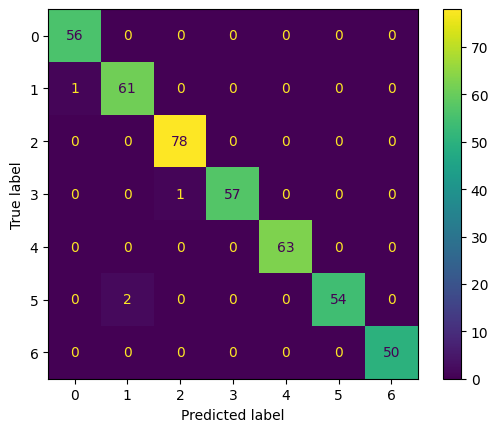

In [39]:
confusionMatrix = confusion_matrix(yTest, predictions)
plt.figure(figsize=(16, 12))
disp = ConfusionMatrixDisplay(confusion_matrix = confusionMatrix)
disp.plot()
plt.show()

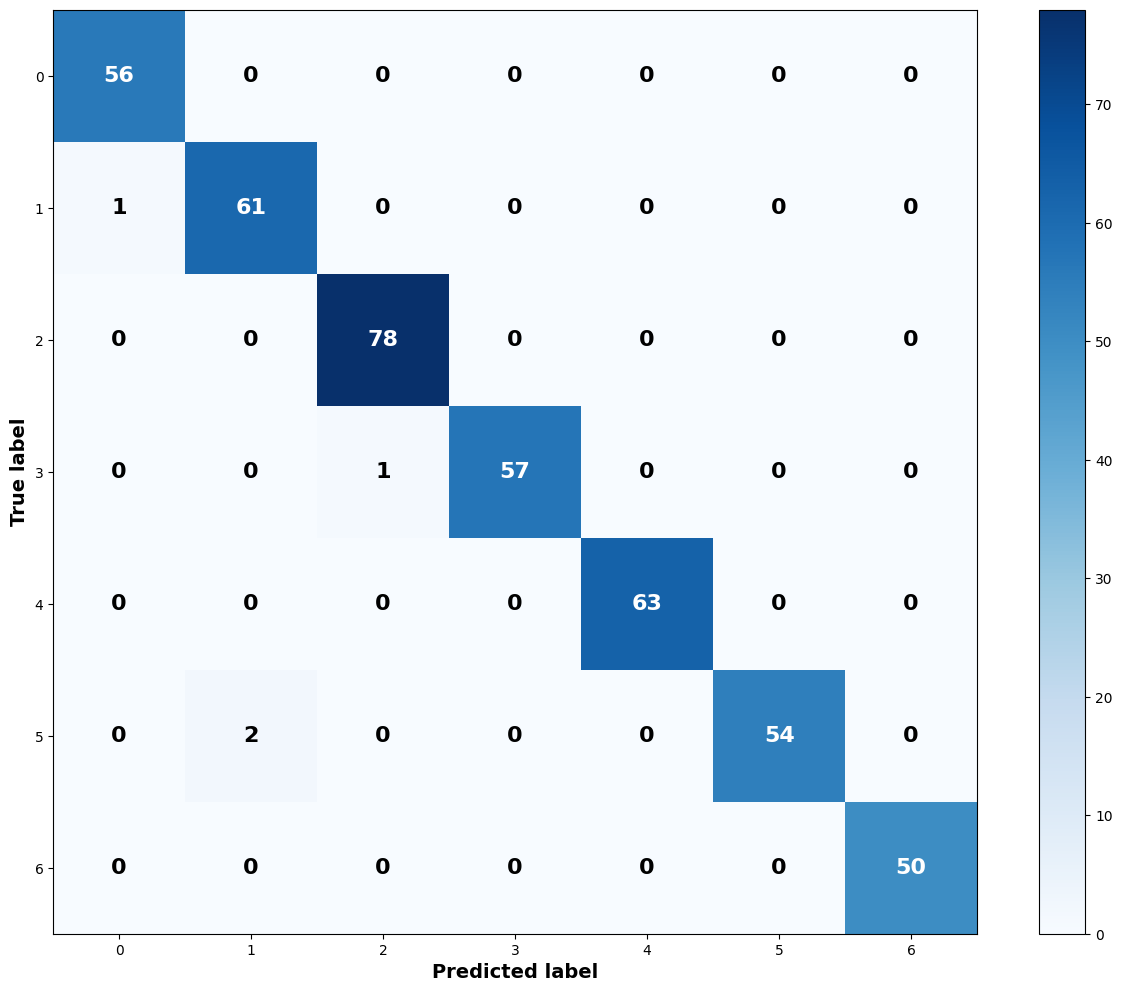

In [45]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Compute confusion matrix
confusionMatrix = confusion_matrix(yTest, predictions)

# Plot confusion matrix with custom color mapping (change purple to white)
plt.figure(figsize=(16, 12))
plt.imshow(confusionMatrix, interpolation='nearest', cmap=plt.cm.Blues)

# Customize color mapping: change purple (e.g., 'magenta') to white
threshold = confusionMatrix.max() / 2.0  # Adjust threshold as needed
for i in range(confusionMatrix.shape[0]):
    for j in range(confusionMatrix.shape[1]):
        plt.text(j, i, format(confusionMatrix[i, j], '.0f'),
                 ha='center', va='center',
                 color='white' if confusionMatrix[i, j] > threshold else 'black', fontweight='bold', fontsize=16)

plt.xlabel('Predicted label', fontweight='bold', fontsize=14)  # Set x-axis label font weight to 'bold' and font size to 14
plt.ylabel('True label', fontweight='bold', fontsize=14)
plt.colorbar()
plt.show()


##  **Save the model**

In [86]:
import os

# Define the folder name
folder_name = "models"

# Define the path to the folder
folder_path = "/kaggle/working/" + folder_name

# Create the folder
os.makedirs(folder_path)

print(f"Folder '{folder_name}' created successfully at {folder_path}")


Folder 'models' created successfully at /kaggle/working/models


In [17]:
import pickle

# Save the StackingClassifier model
with open('D:/College Stuff/Semester 6/Homework/Data Mining & Analysis/mlproject/models/new/staxifierV3.pkl', 'wb') as file:
    pickle.dump(staxifier, file)